In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_408.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_222.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_200.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_285.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_210.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_243.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_214.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_323.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_320.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_272.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_309.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_343.jpg
/kag

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Path to your dataset folder
dataset_path = '/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset'

# Data augmentation + normalization
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

# Training generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # training split
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # validation split
    shuffle=False
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Base pretrained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Add custom layers on top
from tensorflow.keras.layers import Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  
from tensorflow.keras.regularizers import l2

x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)

x = Dropout(0.4)(x)         
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


# Complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers (transfer learning)
for layer in base_model.layers[:120]:
    layer.trainable = False
for layer in base_model.layers[120:]:
    layer.trainable = True


# Compile with a lower LR
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(1e-5),   # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1828 - loss: 2.4208 - val_accuracy: 0.2903 - val_loss: 1.8015
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2583 - loss: 1.9865 - val_accuracy: 0.4414 - val_loss: 1.5291
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3508 - loss: 1.7548 - val_accuracy: 0.5030 - val_loss: 1.3777
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4179 - loss: 1.5987 - val_accuracy: 0.5805 - val_loss: 1.2155
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4787 - loss: 1.4417 - val_accuracy: 0.6143 - val_loss: 1.1624
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5138 - loss: 1.4087 - val_accuracy: 0.6561 - val_loss: 1.0888
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5726 - loss: 1.2646 - val_accuracy: 0.6918 - val_loss: 1.0177
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5960 - loss: 1.2033 - val_accuracy: 0.6839 - val_loss

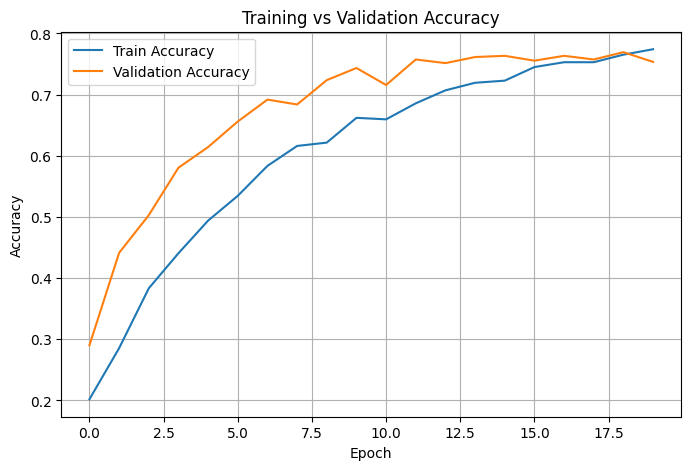

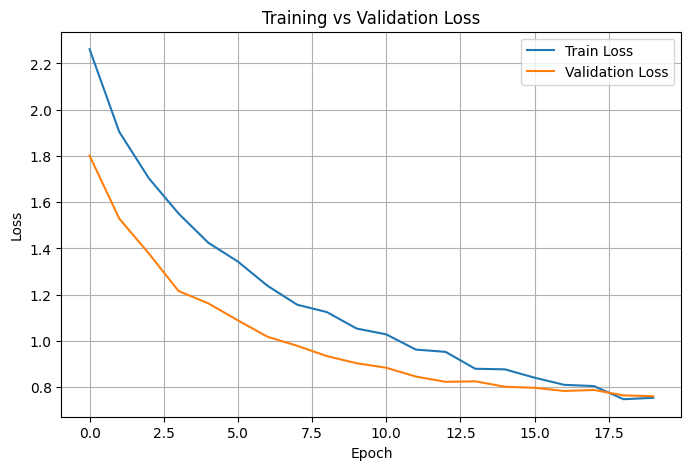

In [20]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# Full pipeline: build CSV -> Sequence generator -> train multi-label model -> export TFLite (int8)


import os
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split


dataset_path = "/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset"  
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SEED = 42

# Meta classes in fixed order (this order -> output neuron order)
META_CLASSES = ['recyclable', 'organic', 'harmful']

# Fine -> meta multi-label mapping (as you specified)
fine_to_meta = {
    'plastic':    ['recyclable', 'harmful'],
    'metal':      ['harmful'],
    'paper':      ['recyclable', 'organic'],
    'cardboard':  ['recyclable', 'organic'],
    'glass':      ['recyclable'],
}

# ---------- 1) Build DataFrame containing filepaths and multi-hot labels ----------
rows = []
p = Path(dataset_path)

for fine_dir in sorted(os.listdir(dataset_path)):
    dirpath = p / fine_dir
    if not dirpath.is_dir(): 
        continue
    for fname in os.listdir(dirpath):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        filepath = str(dirpath / fname)
        fine_label = fine_dir  # e.g., "plastic"
        meta_labels = fine_to_meta.get(fine_label, [])
        # multi-hot vector in same order as META_CLASSES
        label_vec = [1 if mc in meta_labels else 0 for mc in META_CLASSES]
        rows.append({
            'filepath': filepath,
            'fine_label': fine_label,
            'labels': label_vec
        })

df = pd.DataFrame(rows)
print("Total images found:", len(df))
df.head()

# ---------- 2) Train/Validation split ----------
train_df, val_df = train_test_split(df, test_size=0.20, random_state=SEED, shuffle=True, stratify=df['fine_label'])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("Train:", len(train_df), "Val:", len(val_df))

# ---------- 3) Image augmentation config (ImageDataGenerator used only for transforms) ----------
# We'll use ImageDataGenerator.random_transform() per-image inside a custom Sequence
aug_gen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    channel_shift_range=20  # small channel shifts to simulate lighting changes
)

# ---------- 4) Custom Sequence for multi-label training ----------
class MultiLabelSequence(Sequence):
    def __init__(self, df, batch_size, img_size, aug_gen=None, preprocess_fn=None, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_h, self.img_w = img_size
        self.aug = aug_gen
        self.preprocess_fn = preprocess_fn
        self.indexes = np.arange(len(self.df))
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_files = self.df.iloc[batch_indexes]
        batch_x = np.zeros((len(batch_files), self.img_h, self.img_w, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_files), len(META_CLASSES)), dtype=np.float32)
        for i, (_, row) in enumerate(batch_files.iterrows()):
            # load
            img = load_img(row['filepath'], target_size=(self.img_h, self.img_w))
            x = img_to_array(img)  # floats
            # apply augmentation (random_transform expects rank-3 image)
            if self.aug is not None:
                x = self.aug.random_transform(x)
            # MobileNetV2 preprocessing
            if self.preprocess_fn is not None:
                x = self.preprocess_fn(x)
            batch_x[i] = x
            batch_y[i] = np.array(row['labels'], dtype=np.float32)
        return batch_x, batch_y

# Instantiate sequences
train_seq = MultiLabelSequence(train_df, BATCH_SIZE, IMG_SIZE, aug_gen, preprocess_input, shuffle=True)
val_seq = MultiLabelSequence(val_df, BATCH_SIZE, IMG_SIZE, None, preprocess_input, shuffle=False)  # no augmentation for val

# ---------- 5) Build model: MobileNetV2 base + top for multi-label ----------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Freeze most layers initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = Dropout(0.4)(x)
outputs = Dense(len(META_CLASSES), activation='sigmoid')(x)  # sigmoid for multi-label

model = Model(inputs=base_model.input, outputs=outputs)


# compile
model.compile(
    optimizer=Adam(1e-4),  # start with a small LR
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


# ---------- 7) Train (stage 1: top only) ----------
history1 = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,

)

# ---------- 8) Fine-tuning: unfreeze last blocks and continue ----------
# Unfreeze some deeper base layers for fine-tuning
for layer in base_model.layers[-40:]:  # last 40 layers
    layer.trainable = True

# recompile with lower LR
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history2 = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=10,
    
)

# Save final Keras model
model.save("waste_multilabel_mobilenetv2.h5")
print("Saved Keras model: waste_multilabel_mobilenetv2.h5")
# keras latency 
import time

def measure_latency_keras(model, img_path, IMG_SIZE):
    img = load_img(img_path, target_size=IMG_SIZE)
    x = img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    # Warm-up run
    _ = model.predict(x)

    # Timed run
    start = time.time()
    _ = model.predict(x)
    end = time.time()

    print("Keras model latency:", round((end - start) * 1000, 3), "ms")


# pick a sample
test_img = val_df.iloc[0]["filepath"]
measure_latency_keras(model, test_img, IMG_SIZE)


# ---------- 9) Export to TFLite with int8 quantization ----------
# We will create a representative dataset generator that yields sample images (preprocessed)
def representative_data_gen():
    # pick up to 100 samples from train_df
    sample_paths = train_df['filepath'].sample(n=min(100, len(train_df)), random_state=SEED).tolist()
    for pth in sample_paths:
        img = load_img(pth, target_size=IMG_SIZE)
        x = img_to_array(img)
        x = preprocess_input(x)
        x = np.expand_dims(x.astype(np.float32), axis=0)
        yield [x]

# Convert to TFLite (full integer quantization - int8)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure integer only ops for max compatibility
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

try:
    tflite_model = converter.convert()
    with open("waste_multilabel_int8.tflite", "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite int8 model: waste_multilabel_int8.tflite")
except Exception as e:
    print("TFLite conversion failed:", e)
    # Fallback: try dynamic range quantization
    conv2 = tf.lite.TFLiteConverter.from_keras_model(model)
    conv2.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model2 = conv2.convert()
    with open("waste_multilabel_dynamic.tflite", "wb") as f:
        f.write(tflite_model2)
    print("Saved fallback dynamic-quant model: waste_multilabel_dynamic.tflite")
    # tfLite latency
def measure_latency_tflite(tflite_path, img_path, IMG_SIZE):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_index = input_details['index']

    # Read & preprocess image
    img = load_img(img_path, target_size=IMG_SIZE)
    x = img_to_array(img)
    x = preprocess_input(x)

    # Quantize float → int8
    scale, zero_point = input_details['quantization']
    x = np.expand_dims(x, axis=0).astype(np.float32)
    x_int8 = (x / scale + zero_point).astype(np.int8)

    # Warm-up
    interpreter.set_tensor(input_index, x_int8)
    interpreter.invoke()

    # Timed run
    start = time.time()
    interpreter.set_tensor(input_index, x_int8)
    interpreter.invoke()
    end = time.time()

    print("TFLite INT8 latency:", round((end - start) * 1000, 3), "ms")


# Measure
measure_latency_tflite("waste_multilabel_int8.tflite", test_img, IMG_SIZE)


# ---------- 10) Quick inference helper (example) ----------
# use keras model for quick CPU inference example
def predict_image_keras(img_path, top_thresh=0.5):
    img = load_img(img_path, target_size=IMG_SIZE)
    x = img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]  # vector of 3 sigmoids
    out = {META_CLASSES[i]: float(preds[i]) for i in range(len(META_CLASSES))}
    labels = [k for k, v in out.items() if v >= top_thresh]
    return out, labels

# Quick test on a sample val image
if len(val_df) > 0:
    sample = val_df.iloc[0]['filepath']
    scores, pred_labels = predict_image_keras(sample, top_thresh=0.4)
    print("Sample:", sample)
    print("Scores:", scores)
    print("Predicted labels (>=0.4):", pred_labels)


2025-12-04 08:57:09.864633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764838630.123017      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764838630.200915      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Total images found: 2527
Train: 2021 Val: 506


2025-12-04 08:57:28.470285: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5618 - auc: 0.6242 - loss: 0.8900 - val_accuracy: 0.7964 - val_auc: 0.8691 - val_loss: 0.5854
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7135 - auc: 0.8257 - loss: 0.6295 - val_accuracy: 0.7747 - val_auc: 0.9208 - val_loss: 0.5006
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7189 - auc: 0.8811 - loss: 0.5478 - val_accuracy: 0.7312 - val_auc: 0.9398 - val_loss: 0.4536
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6866 - auc: 0.8992 - loss: 0.5142 - val_accuracy: 0.7589 - val_auc: 0.9487 - val_loss: 0.4237
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7140 - auc: 0.9182 - loss: 0.4754 - val_accuracy: 0.7391 - val_auc: 0.9546 - val_loss: 0.4041
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7170 - auc: 0.9129 - loss: 0.4852 - val_accuracy: 0.7115 - val_auc: 0.9583 - val_loss: 0.3890
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - 

Saved Keras model: waste_multilabel_mobilenetv2.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Keras model latency: 110.943 ms
INFO:tensorflow:Assets written to: /tmp/tmp2r04hoxa/assets


INFO:tensorflow:Assets written to: /tmp/tmp2r04hoxa/assets


Saved artifact at '/tmp/tmp2r04hoxa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  131953295879888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295880656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295882576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295882192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295881040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295882768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295881808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295880080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295882960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131953295880848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13195329588334

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764840256.935004      47 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764840256.935079      47 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1764840257.120423      47 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Saved TFLite int8 model: waste_multilabel_int8.tflite
TFLite INT8 latency: 15.829 ms
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Sample: /kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/plastic/plastic_079.jpg
Scores: {'recyclable': 0.9862611293792725, 'organic': 0.0011594241950660944, 'harmful': 0.5707178115844727}
Predicted labels (>=0.4): ['recyclable', 'harmful']


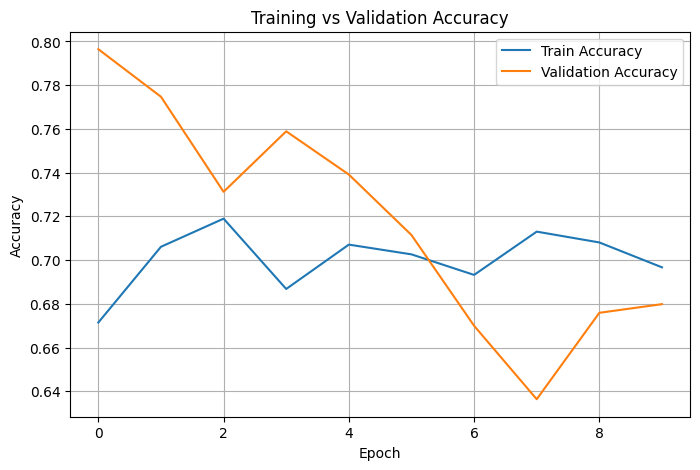

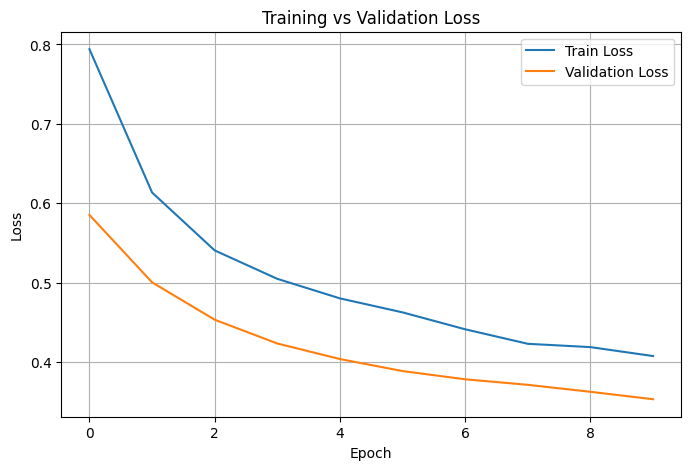

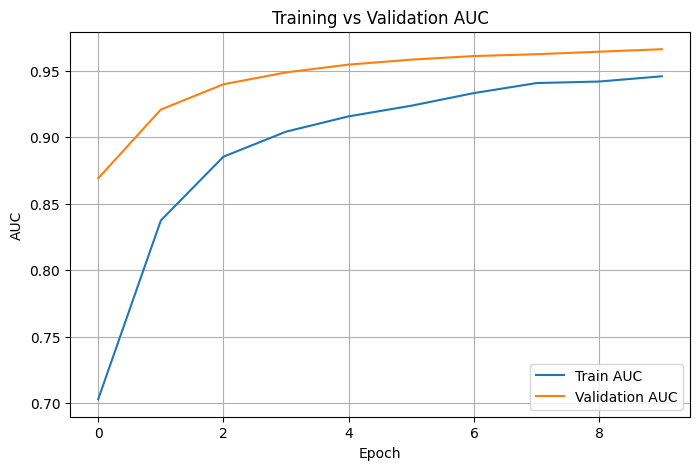

In [4]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(8,5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.plot(history1.history['auc'], label='Train AUC')
plt.plot(history1.history['val_auc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()
